In [44]:
import pandas as pd
from pandas.io.json import json_normalize
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn 
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import tree
from sklearn import ensemble
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import feature_extraction as fe

from xgboost import XGBClassifier


In [4]:
with open('train.json', 'r') as f:
    datastore = json.load(f)

In [5]:
for recipe in datastore:
    new_ingredients = [i.lower().replace("-", ' ').replace('(', "").replace(')', "").split(',', 1)[0] 
                       for i in recipe['ingredients']]
    recipe['ingredients'] = " ".join(new_ingredients).split(" ")

In [6]:
df = pd.DataFrame.from_dict(json_normalize(datastore), orient='columns')

### Turn into one hot columns

In [7]:
df.head(), df.shape

(       cuisine     id                                        ingredients
 0        greek  10259  [romaine, lettuce, black, olives, grape, tomat...
 1  southern_us  25693  [plain, flour, ground, pepper, salt, tomatoes,...
 2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking, oil, ...
 3       indian  22213               [water, vegetable, oil, wheat, salt]
 4       indian  13162  [black, pepper, shallots, cornflour, cayenne, ...,
 (39774, 3))

In [8]:
v = df.ingredients.values
l = [len(x) for x in v.tolist()]
f, u = pd.factorize(np.concatenate(v))
n, m = len(v), u.size
i = np.arange(n).repeat(l)

dummies = pd.DataFrame(
    np.bincount(i * m + f, minlength=n * m).reshape(n, m),
    df.index, u
)

one_hot = pd.concat([df.drop('ingredients', 1), dummies.drop('cuisine', 1)], axis=1)
#one_hot = df.drop(['individ_ingredients', 'ingredients', 'new_ingredients'], 1).join(dummies)

### Processing Data

In [58]:
one_hot.head()

cuisine     id  romaine  lettuce  black  olives  grape  tomatoes  \
0        greek  10259        1        1      1       1      1         1   
1  southern_us  25693        0        0      1       0      0         2   
2     filipino  20130        0        0      0       0      0         0   
3       indian  22213        0        0      0       0      0         0   
4       indian  13162        0        0      1       0      0         0   

   garlic  pepper  ...  makers  mark  ketjap  daiya  slim  cotto  challenge  \
0       1       1  ...       0     0       0      0     0      0          0   
1       0       2  ...       0     0       0      0     0      0          0   
2       1       1  ...       0     0       0      0     0      0          0   
3       0       0  ...       0     0       0      0     0      0          0   
4       1       2  ...       0     0       0      0     0      0          0   

   brew  lop  chong  
0     0    0      0  
1     0    0      0  
2     0    0      0  
3     0    0      0  
4     0    0      0  

[5 rows x 3055 columns]

In [60]:
one_hot.shape

(39774, 3055)

In [18]:
X = one_hot[one_hot.columns.difference(['cuisine', 'id'])]
y = one_hot['cuisine']

In [19]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=43)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31819, 3053), (7955, 3053), (31819,), (7955,))

In [21]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### TF - IDF

In [22]:
tfidf = fe.text.TfidfTransformer()

## Train/Test

In [73]:
# Get the indices for cross v alidation
fold_generator = ms.KFold(5, shuffle=True, random_state=14)

In [90]:
models = {#'dt1': sklearn.tree.DecisionTreeClassifier(max_depth=5), 
          #'dt2': sklearn.tree.DecisionTreeClassifier(max_depth=25), 
          #'et1': sklearn.ensemble.ExtraTreesClassifier(n_estimators=50, max_depth=5),
          #'et2': sklearn.ensemble.ExtraTreesClassifier(n_estimators=100, max_depth=5),
          #'et3': sklearn.ensemble.ExtraTreesClassifier(n_estimators=1000, max_depth=5),
          #'et4': sklearn.ensemble.ExtraTreesClassifier(n_estimators=50),
          #'et5': sklearn.ensemble.ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
          #'et6': sklearn.ensemble.ExtraTreesClassifier(n_estimators=1000,  n_jobs=-1), 
          #'SVC1': sklearn.svm.LinearSVC(C=0.001, multi_class="crammer_singer"),
          #'SVC2': sklearn.svm.LinearSVC(C=0.01, multi_class="crammer_singer"),
          #'SVC3': sklearn.svm.LinearSVC(C=.1, multi_class="crammer_singer"),
          #'SVC4': sklearn.svm.LinearSVC(C=1.0, multi_class="crammer_singer"),
          #'SVC5': sklearn.svm.LinearSVC(C=2.0, multi_class="crammer_singer"),
          #'SVC6': sklearn.svm.LinearSVC(C=5.0, multi_class="crammer_singer"),
          #'SVC7': sklearn.svm.LinearSVC(C=10.0, multi_class="crammer_singer"),
          #'SVC8': sklearn.svm.LinearSVC(C=1.0, multi_class="crammer_singer", class_weight='balanced'),
          #'SVC9': sklearn.svm.LinearSVC(C=2.0, multi_class="crammer_singer", class_weight='balanced'),
          #'lr1': sklearn.linear_model.LogisticRegression(C=0.01, solver='saga', multi_class='multinomial'),
          #'lr2': sklearn.linear_model.LogisticRegression(C=0.1, solver='saga', multi_class='multinomial'),
          'lr3': sklearn.linear_model.LogisticRegression(C=1.0, solver='saga', multi_class='multinomial'),
          'lr4': sklearn.linear_model.LogisticRegression(C=2.0, solver='saga', multi_class='multinomial'),
          'lr5': sklearn.linear_model.LogisticRegression(C=5.0, solver='saga', multi_class='multinomial'),
          'lr6': sklearn.linear_model.LogisticRegression(C=10.0, solver='saga', multi_class='multinomial'),
          'lr7': sklearn.linear_model.LogisticRegression(C=20.0, solver='saga', multi_class='multinomial'),
          'lr8': sklearn.linear_model.LogisticRegression(C=30.0, solver='saga', multi_class='multinomial'),
          #'rf1': sklearn.ensemble.RandomForestClassifier(max_depth=5),
          #'rf2': sklearn.ensemble.RandomForestClassifier(max_depth=10),
          #'ridge1': sklearn.linear_model.RidgeClassifier(alpha=0.5),
          #'ridge2': sklearn.linear_model.RidgeClassifier(alpha=2.0)
}

In [91]:
models_list = []
fold_id_list = []
micro_scores_list = []
macro_scores_list = []
accuracies_list = []

fold_id = 0
for train_index, test_index in fold_generator.split(X_train):
    print(fold_id)
    
    for name, model in models.items():
        print(name)
        
        # Slice 
        X_this_train, X_this_test = X_train.loc[train_index], X_train.loc[test_index]
        y_this_train, y_this_test = y_train[train_index], y_train[test_index]
        
        # TF-IDF 
        X_this_train = tfidf.fit_transform(X_this_train)
        X_this_test = tfidf.transform(X_this_test)
        
        # Fit
        this_fit = model.fit(X_this_train, y_this_train)
        predicted = model.predict(X_this_test)
        
        # Score
        micro_score = metrics.f1_score(y_this_test, predicted, average='micro')
        macro_score = metrics.f1_score(y_this_test, predicted, average='macro')
        accuracy = metrics.accuracy_score(y_this_test, predicted)
        
        models_list.append(name)
        fold_id_list.append(fold_id)
        micro_scores_list.append(micro_score)
        macro_scores_list.append(macro_score)
        accuracies_list.append(accuracy)
    
    fold_id += 1
        


0
lr3
lr4
lr5
lr6
lr7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1
lr3
lr4
lr5
lr6
lr7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2
lr3
lr4
lr5
lr6
lr7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


3
lr3
lr4
lr5
lr6
lr7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


4
lr3
lr4
lr5
lr6
lr7


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


lr8


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [92]:
results = pd.DataFrame({'fold':fold_id_list, "model":models_list, 
                        "micro_f1":micro_scores_list, 'macro_f1':macro_scores_list,
                       "accuracy":accuracies_list})

In [93]:
results.groupby('model')[['micro_f1', 'macro_f1', 'accuracy']].mean()

micro_f1  macro_f1  accuracy
model                              
lr3    0.777209  0.693049  0.777209
lr4    0.783494  0.706829  0.783494
lr5    0.784311  0.710513  0.784311
lr6    0.779817  0.705225  0.779817
lr7    0.774003  0.697866  0.774003
lr8    0.769163  0.691402  0.769163

# Final Model Test

In [122]:
X_train_scaled = tfidf.fit_transform(X_train)
X_test_scaled = tfidf.transform(X_test)

In [48]:
final_model = sklearn.linear_model.LogisticRegression(C=5, solver='saga', multi_class='multinomial')

In [49]:
final_fit = final_model.fit(X_train_scaled, y_train)
final_predicted = final_model.predict(X_test_scaled)

In [50]:
micro_score = metrics.f1_score(y_test, final_predicted, average='micro')
macro_score = metrics.f1_score(y_test, final_predicted, average='macro')
accuracy = metrics.accuracy_score(y_test, final_predicted)

In [52]:
one_hot.cuisine.value_counts(normalize=True)

italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64

In [127]:
micro_score, macro_score, accuracy

(0.7909490886235073, 0.7192211007570548, 0.7909490886235072)

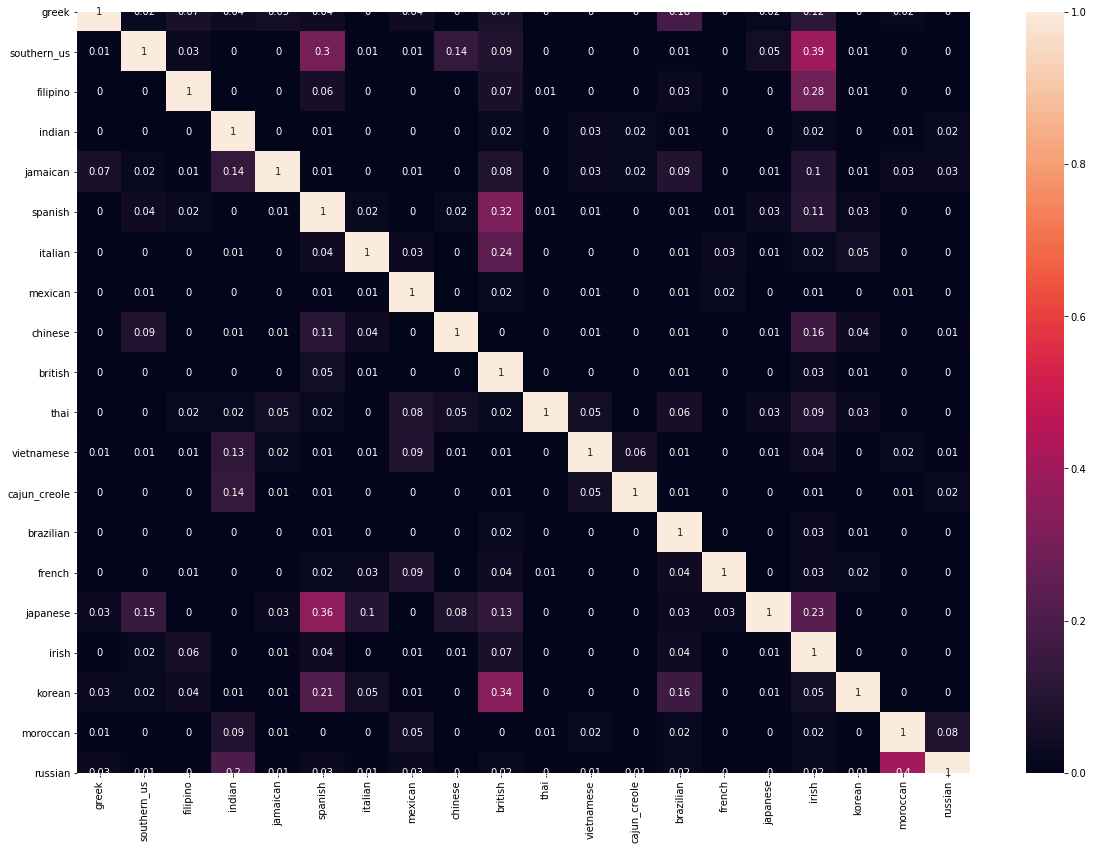

In [51]:
conf_mat = metrics.confusion_matrix(y_test, final_predicted)
cm_df = pd.DataFrame(
   conf_mat, 
   index = [idx for idx in one_hot.cuisine.unique()],
   columns = [col for col in one_hot.cuisine.unique()])

cm_df_n = cm_df.div(cm_df.max(axis=1), axis=0)

plt.figure(figsize = (20,14))
sns.heatmap(cm_df_n.round(2), annot=True)

# XGBOOST Maybe?

In [34]:
xbmodels = {'xb1': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=3),
            'xb2': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=5),
            'xb3': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=8),
            #'xb4': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=10),
            #'xb5': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=15),
            #'xb6': XGBClassifier(objective='multi:softmax', num_class=20, max_depth=20)
           }

In [35]:
# Get the indices for cross validation
xb_fold_generator = ms.KFold(4, shuffle=True, random_state=14)

In [36]:
xb_models_list = []
xb_fold_id_list = []
xb_micro_scores_list = []
xb_macro_scores_list = []
xb_accuracies_list = []

fold_id = 0
for train_index, test_index in xb_fold_generator.split(X_train):
    print(fold_id)
    
    for name, model in xbmodels.items():
        print(name)
        
        # Slice 
        X_this_train, X_this_test = X_train.loc[train_index], X_train.loc[test_index]
        y_this_train, y_this_test = y_train[train_index], y_train[test_index]
        
        # TF-IDF 
        X_this_train = tfidf.fit_transform(X_this_train)
        X_this_test = tfidf.transform(X_this_test)
        
        # Fit
        this_fit = model.fit(X_this_train, y_this_train)
        predicted = model.predict(X_this_test)
        
        # Score
        micro_score = metrics.f1_score(y_this_test, predicted, average='micro')
        macro_score = metrics.f1_score(y_this_test, predicted, average='macro')
        accuracy = metrics.accuracy_score(y_this_test, predicted)
        
        xb_models_list.append(name)
        xb_fold_id_list.append(fold_id)
        xb_micro_scores_list.append(micro_score)
        xb_macro_scores_list.append(macro_score)
        xb_accuracies_list.append(accuracy)
    
    fold_id += 1

0
xb1
xb2
xb3
1
xb1
xb2
xb3
2
xb1
xb2
xb3
3
xb1
xb2
xb3


In [37]:
xb_results = pd.DataFrame({'fold':xb_fold_id_list, "model":xb_models_list, 
                           "micro_f1":xb_micro_scores_list, 'macro_f1':xb_macro_scores_list,
                       "accuracy":xb_accuracies_list})

In [38]:
xb_results.groupby('model')[['micro_f1', 'macro_f1', 'accuracy']].mean()

micro_f1  macro_f1  accuracy
model                              
xb1    0.724567  0.641142  0.724567
xb2    0.747855  0.669125  0.747855
xb3    0.758729  0.679174  0.758729

### Final Model

In [39]:
X_train_scaled = tfidf.fit_transform(X_train)
X_test_scaled = tfidf.transform(X_test)

In [40]:
xb_final_model = XGBClassifier(objective='multi:softmax', num_class=20, max_depth=15)

In [41]:
xb_final_fit = xb_final_model.fit(X_train_scaled, y_train)
xb_final_predicted = xb_final_model.predict(X_test_scaled)

In [42]:
micro_score =    metrics.f1_score(y_test, xb_final_predicted, average='micro')
macro_score =    metrics.f1_score(y_test, xb_final_predicted, average='macro')
accuracy = metrics.accuracy_score(y_test, xb_final_predicted)

In [43]:
micro_score, macro_score, accuracy

(0.7742300439974859, 0.6964513700908473, 0.7742300439974859)

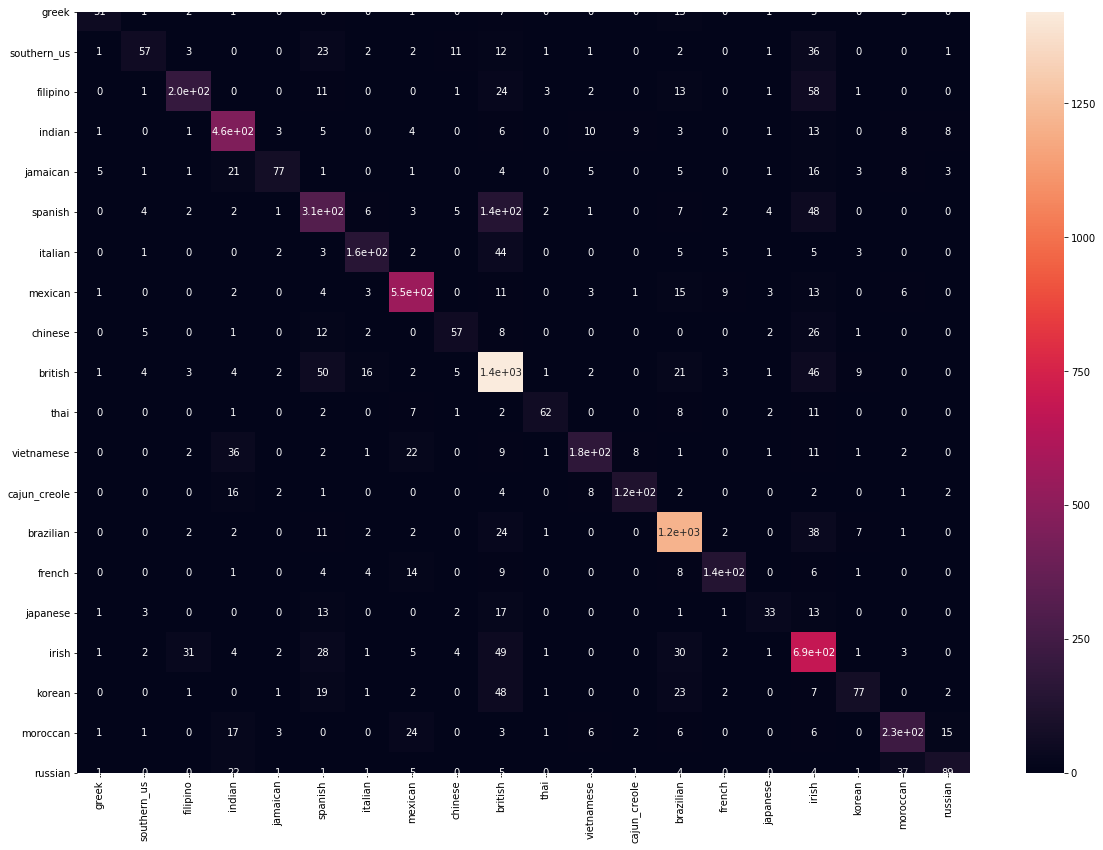

In [53]:
conf_mat = metrics.confusion_matrix(y_test, xb_final_predicted)
cm_df = pd.DataFrame(
   conf_mat, 
   index = [idx for idx in one_hot.cuisine.unique()],
   columns = [col for col in one_hot.cuisine.unique()])

cm_df_n = cm_df.div(cm_df.max(axis=1), axis=0)

plt.figure(figsize = (20,14))
sns.heatmap(cm_df.round(2), annot=True)